# Chủ đề: Phân tích cảm xúc học sinh từ phản hồi khóa học dựa trên khía cạnh (Aspect-Based Sentiment Analysis) nhằm cải thiện thiết kế giảng dạy/UIT-VSFC

## Người thực hiện: Nguyễn Thị Thu Trang
## MSSV: 22028254

# I. Cài đặt, import các thư viện

In [1]:
!pip install gdown

In [2]:
import gdown
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten, BatchNormalization, SimpleRNN
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten, LSTM, Bidirectional
import warnings
warnings.filterwarnings('ignore')
import os
import seaborn as sns
import torch
from torch.utils.data import Dataset
from transformers import AutoModel, AutoTokenizer
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

2025-12-19 15:01:49.282485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766156509.304223     207 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766156509.310725     207 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. HuggingFace + PyTorch

In [3]:
# HuggingFace + PyTorch
!pip install -q transformers torch sentencepiece

## 2. VNCoreNLP (RDRSegmenter)

In [4]:
# Cài đặt wrapper Python cho VnCoreNLP.
!pip install vncorenlp

# Tải xuống VnCoreNLP và thành phần phân đoạn từ (RDRSegmenter).
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2025-12-19 15:02:04--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.08s   

2025-12-19 15:02:04 (314 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2025-12-19 15:02:04--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting respon

In [5]:
from vncorenlp import VnCoreNLP
# Khởi tạo RDRSegmenter từ VnCoreNLP để phân đoạn từ tiếng Việt.
rdrsegmenter = VnCoreNLP(
    "vncorenlp/VnCoreNLP-1.1.1.jar", 
    annotators="wseg", 
    max_heap_size='-Xmx500m')

text = "Học viện Công nghệ Bưu chính Viễn thông đón đầu xu hướng công nghệ cao."

# Phân đoạn từ cho đoạn văn bản tiếng Việt.
word_segmented_text = rdrsegmenter.tokenize(text)
print(word_segmented_text)

[['Học_viện', 'Công_nghệ', 'Bưu_chính', 'Viễn_thông', 'đón_đầu', 'xu_hướng', 'công_nghệ_cao', '.']]


In [6]:
def word_segment(text):
    return " ".join(rdrsegmenter.tokenize(text)[0])

## 3. Load PhoBERT bằng AutoTokenizer & AutoModel

In [7]:
!pip uninstall -y transformers huggingface_hub tokenizers
!pip install transformers==4.36.2 huggingface_hub==0.19.4 tokenizers==0.15.2

Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: huggingface-hub 0.36.0
Uninstalling huggingface-hub-0.36.0:
  Successfully uninstalled huggingface-hub-0.36.0
Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
Using cached huggingface_hub-0.19.4-py3-none-any.whl (311 kB)
Using cached tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source

In [8]:
# Source - https://stackoverflow.com/a
# Posted by ANURAG SINGH BHANDARI, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-19, License - CC BY-SA 4.0

!pip install -U transformers huggingface_hub

  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-1.2.3-py3-none-any.whl.metadata (13 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
Using cached tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.19.4
    Uninstalling huggingface-hub-0.19.4:
      Successfully uninstalled huggingface-hub-0.19.4
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Unins

In [9]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(
    "vinai/phobert-base",
    use_fast=False,
    cache_dir="/kaggle/working/"
)

model = AutoModel.from_pretrained(
    "vinai/phobert-base",
    cache_dir="/kaggle/working/"
)

print("Load PhoBERT OK")

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Load PhoBERT OK


In [10]:
# sentence = "chất lượng giảng dạy rất tốt"

# encoded = tokenizer(
#     sentence,
#     padding="max_length",
#     truncation=True,
#     max_length=128,
#     return_tensors="pt"
# )

# print(encoded["input_ids"])
# print(encoded["attention_mask"])

# Tải dữ liệu UIT-VSFC từ Google Drive

In [11]:
# URL gốc trên Google Drive 
URLS = {
    "train": {
        "sentences": "https://drive.google.com/uc?id=1nzak5OkrheRV1ltOGCXkT671bmjODLhP",
        "sentiments": "https://drive.google.com/uc?id=1ye-gOZIBqXdKOoi_YxvpT6FeRNmViPPv",
        "topics": "https://drive.google.com/uc?id=14MuDtwMnNOcr4z_8KdpxprjbwaQ7lJ_C",
    },
    "validation": {
        "sentences": "https://drive.google.com/uc?id=1sMJSR3oRfPc3fe1gK-V3W5F24tov_517",
        "sentiments": "https://drive.google.com/uc?id=1GiY1AOp41dLXIIkgES4422AuDwmbUseL",
        "topics": "https://drive.google.com/uc?id=1DwLgDEaFWQe8mOd7EpF-xqMEbDLfdT-W",
    },
    "test": {
        "sentences": "https://drive.google.com/uc?id=1aNMOeZZbNwSRkjyCWAGtNCMa3YrshR-n",
        "sentiments": "https://drive.google.com/uc?id=1vkQS5gI0is4ACU58-AbWusnemw7KZNfO",
        "topics": "https://drive.google.com/uc?id=1_ArMpDguVsbUGl-xSMkTF_p5KpZrmpSB",
    },
}

# Tải và đọc từng split 
def load_split(name, urls):
    files = {}
    for k, url in urls.items():
        output = f"{name}_{k}.txt"
        gdown.download(url, output, quiet=True)
        files[k] = output

    # Đọc 3 file và gộp lại
    with open(files["sentences"], encoding="utf-8") as f:
        sentences = [line.strip() for line in f]
    with open(files["sentiments"], encoding="utf-8") as f:
        sentiments = [int(line.strip()) for line in f]
    with open(files["topics"], encoding="utf-8") as f:
        topics = [int(line.strip()) for line in f]

    return pd.DataFrame({
        "sentence": sentences,
        "sentiment": sentiments,
        "topic": topics
    })

# Tải từng tập
train_df = load_split("train", URLS["train"])
val_df   = load_split("val", URLS["validation"])
test_df  = load_split("test", URLS["test"])

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [12]:
df_ = pd.concat([train_df, val_df, test_df])
df_ = df_.dropna()
df_ = df_.reset_index(drop=True)
df_

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0
...,...,...,...
16170,"các slide khó hiểu , ngôn ngữ trong slide phức...",0,0
16171,giáo viên giảng dạy có tâm huyết .,2,0
16172,chia sẻ cho em nhiều điều hay .,2,0
16173,em tiếp thu chậm .,0,0


# Chia train / val / test

In [13]:
# Sentiment
train_df, test_df = train_test_split(df_, test_size=0.2, random_state=42, stratify=df_['sentiment'])
train_df, val_df  = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['sentiment'])

# Word segmentation

In [14]:
def word_segment(text):
    return " ".join(rdrsegmenter.tokenize(text)[0])

train_df['segmented'] = train_df['sentence'].apply(word_segment)
val_df['segmented']   = val_df['sentence'].apply(word_segment)
test_df['segmented']  = test_df['sentence'].apply(word_segment)

# TOKENIZATION (AutoTokenizer – PhoBERT)

In [15]:
# from transformers import AutoTokenizer, AutoModel

# tokenizer = AutoTokenizer.from_pretrained(
#     "vinai/phobert-base",
#     use_fast=False
# )

# Dataset class

In [16]:
class PhoBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Tạo dataset cho sentiment

In [17]:
train_dataset = PhoBERTDataset(
    train_df['segmented'].tolist(),
    train_df['sentiment'].tolist(),
    tokenizer
)

val_dataset = PhoBERTDataset(
    val_df['segmented'].tolist(),
    val_df['sentiment'].tolist(),
    tokenizer
)

test_dataset = PhoBERTDataset(
    test_df['segmented'].tolist(),
    test_df['sentiment'].tolist(),
    tokenizer
)

# III. Model

In [18]:
def plot_history(history, model_name="Mô hình"):
    """Vẽ biểu đồ Accuracy và Loss từ lịch sử huấn luyện."""
    
    # Lấy dữ liệu từ đối tượng history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy: Train vs Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss: Train vs Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [19]:
def evaluate_model(model, X_test, y_test, class_names, average='macro', title=None):
    """
    Đánh giá mô hình trên tập test (multi-class).
    In ra Accuracy, Precision, Recall, F1, Confusion Matrix, Classification Report.
    """
    # Dự đoán
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Các độ đo tổng thể
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec = recall_score(y_test, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=0)
    
    print(f"ĐÁNH GIÁ MÔ HÌNH{' - ' + title if title else ''}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # Classification Report chi tiết từng lớp
    print("\nClassification Report")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    # print(cm_df)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {title}" if title else "Confusion Matrix")
    plt.show()
    
    
    # Trả về kết quả để log hoặc lưu
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "cm": cm}

In [29]:
import matplotlib.pyplot as plt

def plot_trainer_history(log_history, model_name="Mô hình"):
    train_loss = []
    eval_loss = []
    eval_acc = []
    epochs = []

    for log in log_history:
        if 'loss' in log and 'epoch' in log:
            train_loss.append(log['loss'])
            epochs.append(log['epoch'])
        if 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            eval_acc.append(log['eval_accuracy'])

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    if eval_loss:
        plt.plot(eval_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Evaluation step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    if eval_acc:
        plt.plot(eval_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Evaluation step')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [20]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

In [21]:
num_labels = train_df['sentiment'].nunique()

model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base",
    num_labels=num_labels
)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",

    eval_strategy="epoch",          # 🔥 ĐỔI TÊN Ở ĐÂY
    save_strategy="epoch",

    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,

    # num_train_epochs=15,
    num_train_epochs=10,

    weight_decay=0.01,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    logging_dir="./logs",
    logging_steps=100,

    report_to="none"               # tắt wandb
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [23]:
import transformers
print(transformers.__version__)

4.57.3


# 13 epoch

In [24]:
history = trainer.train()

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.231900,0.207209,0.934312,0.928059,0.934312,0.925485
2,0.179000,0.195642,0.942813,0.939397,0.942813,0.938126
3,0.145100,0.195449,0.947450,0.944986,0.947450,0.945061
4,0.143100,0.193896,0.948995,0.945579,0.948995,0.945821
5,0.100600,0.218246,0.948223,0.945680,0.948223,0.946537
6,0.103900,0.220949,0.945904,0.943379,0.945904,0.944126
7,0.088700,0.232902,0.945904,0.943368,0.945904,0.944234
8,0.080400,0.239305,0.948223,0.947235,0.948223,0.947621
9,0.050200,0.264963,0.948995,0.946944,0.948995,0.947499
10,0.045700,0.274085,0.946677,0.946025,0.946677,0.946276


SafetensorError: Error while serializing: IoError(Os { code: 28, kind: StorageFull, message: "No space left on device" })

# 10 epoch

In [27]:
history = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.037100,0.303145,0.944359,0.942344,0.944359,0.943115
2,0.029300,0.348044,0.942040,0.939173,0.942040,0.937376
3,0.018900,0.323941,0.948223,0.946095,0.948223,0.946853
4,0.017500,0.364001,0.945904,0.943713,0.945904,0.943449
5,0.017100,0.366010,0.948995,0.947067,0.948995,0.947609
6,0.019900,0.386366,0.947450,0.945483,0.947450,0.946069
7,0.013500,0.389983,0.943586,0.940779,0.943586,0.941752
8,0.006600,0.398442,0.945904,0.944872,0.945904,0.945261
9,0.008200,0.406024,0.947450,0.946428,0.947450,0.946833
10,0.003300,0.403344,0.947450,0.946179,0.947450,0.946618


In [28]:
plot_history(trainer.state.log_history, model_name="PhoBERT Sentiment")

AttributeError: 'list' object has no attribute 'history'

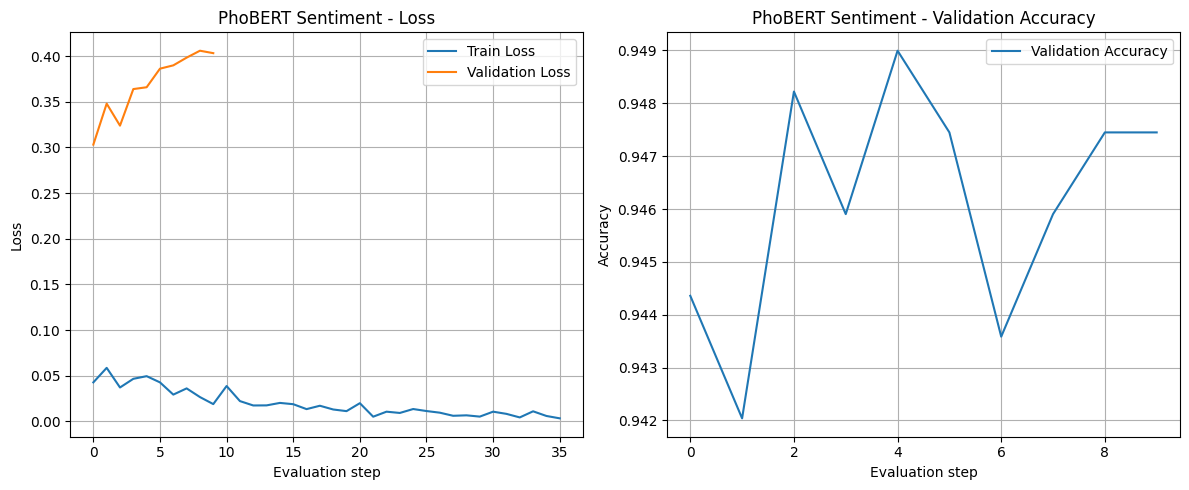

In [31]:
plot_trainer_history(
    trainer.state.log_history,
    model_name="PhoBERT Sentiment"
)

# 13 epoch

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1488
           1       0.70      0.54      0.61       139
           2       0.95      0.97      0.96      1608

    accuracy                           0.95      3235
   macro avg       0.87      0.82      0.84      3235
weighted avg       0.94      0.95      0.94      3235



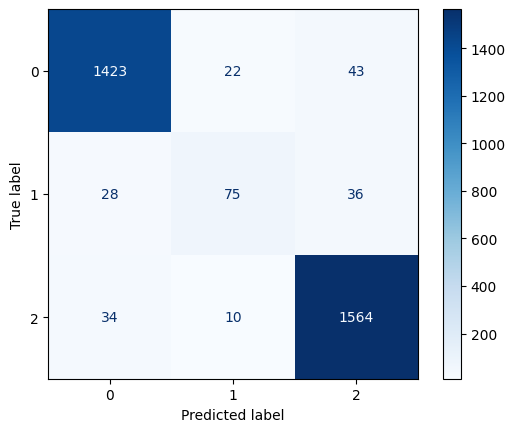

In [25]:
preds = trainer.predict(test_dataset)
y_true = test_df['sentiment'].values
y_pred = np.argmax(preds.predictions, axis=1)

class_names = [str(i) for i in range(num_labels)]

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.show()

# 10 epoch

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1488
           1       0.72      0.54      0.62       139
           2       0.96      0.97      0.96      1608

    accuracy                           0.95      3235
   macro avg       0.88      0.82      0.85      3235
weighted avg       0.95      0.95      0.95      3235



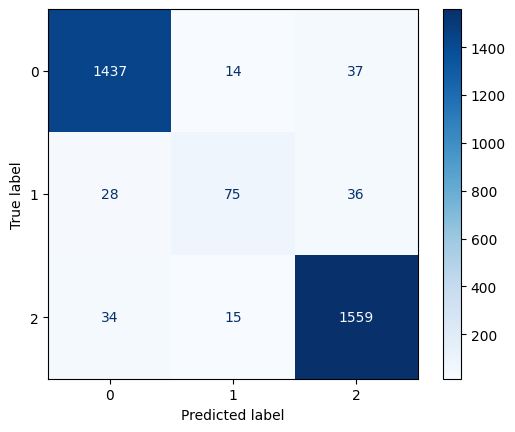

In [30]:
preds = trainer.predict(test_dataset)
y_true = test_df['sentiment'].values
y_pred = np.argmax(preds.predictions, axis=1)

class_names = [str(i) for i in range(num_labels)]

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.show()

# Overfit => Thử tính classweight

In [45]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

labels = train_df['sentiment'].values
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)

Class weights: tensor([0.7248, 7.7177, 0.6708])


In [47]:
import torch.nn as nn
from transformers import Trainer

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # 🔥 ĐƯA class_weights lên đúng device
        loss_fct = nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device)
        )

        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels),
            labels.view(-1)
        )

        return (loss, outputs) if return_outputs else loss

In [48]:
from transformers import AutoModelForSequenceClassification

num_labels = train_df['sentiment'].nunique()

model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base",
    num_labels=num_labels
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",

    eval_strategy="epoch",          # 🔥 ĐỔI TÊN Ở ĐÂY
    save_strategy="epoch",

    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,

    # num_train_epochs=15,
    num_train_epochs=10,

    weight_decay=0.01,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    logging_dir="./logs",
    logging_steps=100,

    report_to="none"               # tắt wandb
)


# Trainer có classweight
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

In [50]:
history = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.418900,0.376099,0.925039,0.941624,0.925039,0.930943
2,0.358100,0.407547,0.945131,0.946041,0.945131,0.945455
3,0.315400,0.450402,0.946677,0.946151,0.946677,0.946137
4,0.287600,0.620899,0.948223,0.945404,0.948223,0.945233
5,0.231100,0.454497,0.951314,0.951317,0.951314,0.951315
6,0.210400,0.531022,0.948223,0.947536,0.948223,0.947766
7,0.165800,0.599704,0.948223,0.947054,0.948223,0.947486
8,0.167100,0.594553,0.950541,0.950832,0.950541,0.950659
9,0.108100,0.659359,0.949768,0.948699,0.949768,0.949137
10,0.110200,0.662351,0.949768,0.948437,0.949768,0.948918


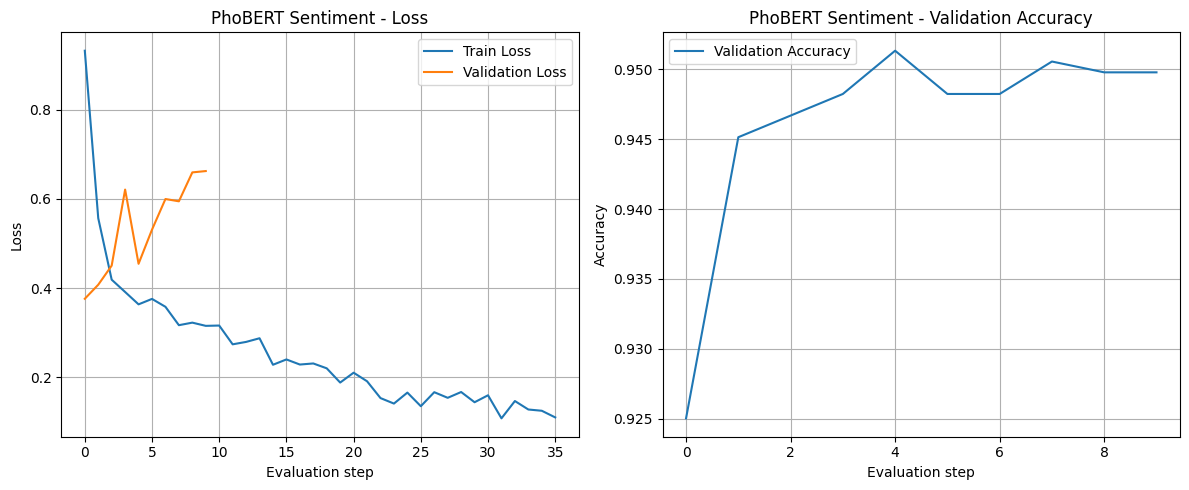

In [51]:
plot_trainer_history(
    trainer.state.log_history,
    model_name="PhoBERT Sentiment"
)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1488
           1       0.65      0.63      0.64       139
           2       0.97      0.96      0.96      1608

    accuracy                           0.95      3235
   macro avg       0.86      0.85      0.85      3235
weighted avg       0.95      0.95      0.95      3235



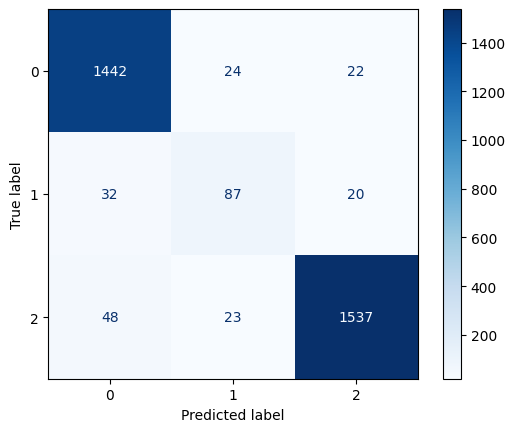

In [52]:
# trainer.train()

preds = trainer.predict(test_dataset)
y_true = test_df['sentiment'].values
y_pred = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

# IV. Phân tích lỗi

## 1. Confusion of labeling

In [ ]:
# best_model = model_dnnt

# # Định nghĩa lại nhãn cho bài toán TOPIC
# topic_names = ['LECTURER', 'CURRICULUM', 'FACILITY', 'OTHER']

# print("Bắt đầu dự đoán trên tập test...")
# Y_pred_probs = best_model.predict(X_test_pad)
# y_pred_indices = np.argmax(Y_pred_probs, axis=1)


# # Lấy các câu gốc từ test_df
# original_sentences = test_df['sentence'].values

# # Tạo một DataFrame để phân tích lỗi
# analysis_df = pd.DataFrame({
#     'sentence': original_sentences,
#     'true_label_index': y_test_topic,
#     'pred_label_index': y_pred_indices
# })

# # Map từ số (index) về tên nhãn (string)
# analysis_df['true_label_name'] = analysis_df['true_label_index'].apply(lambda x: topic_names[x])
# analysis_df['pred_label_name'] = analysis_df['pred_label_index'].apply(lambda x: topic_names[x])

# # Thêm cột 'is_error' để lọc
# analysis_df['is_error'] = analysis_df['true_label_index'] != analysis_df['pred_label_index']

# print(f"\nTổng số câu trong tập test: {len(analysis_df)}")
# print(f"Tổng số câu dự đoán SAI: {analysis_df['is_error'].sum()}")

# print("\nConfusion Matrix (True vs. Predicted):")
# # Đây chính là công cụ tạo ra con số "164" trong paper
# cm = pd.crosstab(
#     analysis_df['true_label_name'], 
#     analysis_df['pred_label_name'],
#     rownames=['True Label'], 
#     colnames=['Predicted Label']
# )
# print(cm)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix - Topic Classification')
# plt.show()


# print("\nPHÂN TÍCH LỖI: CURRICULUM (True) bị nhầm thành LECTURER (Pred)")

# error_filter = (analysis_df['true_label_name'] == 'CURRICULUM') & \
#                (analysis_df['pred_label_name'] == 'LECTURER')

# specific_errors_df = analysis_df[error_filter]

# print(f"\nTìm thấy {len(specific_errors_df)} câu bị nhầm 'CURRICULUM' -> 'LECTURER'.")
# # print("------------------------------------------------------------------")

# # In ra 10 ví dụ lỗi đầu tiên
# for index, row in specific_errors_df.head(10).iterrows():
#     print(f"Câu: {row['sentence']}")
#     print(f"Nhãn thật: {row['true_label_name']} / Dự đoán: {row['pred_label_name']}\n")

#### => Nhiều câu là Lecturer nhưng lại gán nhãn là Curriculum

In [ ]:
# if 'analysis_df' not in locals():
#     Y_pred_probs = best_model.predict(X_test_pad)
#     y_pred_indices = np.argmax(Y_pred_probs, axis=1)
    
#     analysis_df = pd.DataFrame({
#         'sentence': test_df['sentence'].values,
#         'true_label_index': y_test_topic,
#         'pred_label_index': y_pred_indices
#     })
#     analysis_df['true_label_name'] = analysis_df['true_label_index'].apply(lambda x: topic_names[x])
#     analysis_df['pred_label_name'] = analysis_df['pred_label_index'].apply(lambda x: topic_names[x])
#     analysis_df['is_error'] = analysis_df['true_label_index'] != analysis_df['pred_label_index']


# # Lọc ra tất cả các câu bị dự đoán sai
# errors_df = analysis_df[analysis_df['is_error'] == True]

# # Đếm số lần xuất hiện của mỗi cặp lỗi (True, Pred)
# confusion_pairs = errors_df.groupby(['true_label_name', 'pred_label_name']).size()

# # Sắp xếp để xem cặp nào bị nhầm nhiều nhất
# top_errors = confusion_pairs.sort_values(ascending=False)

# print("\nBẢNG XẾP HẠNG CÁC CẶP LỖI PHỔ BIẾN NHẤT:")
# display(top_errors)

# # Lấy 3 cặp lỗi hàng đầu
# for i, ((true_label, pred_label), count) in enumerate(top_errors.head(3).items()):
    
#     print(f"\n#Lỗi phổ biến thứ {i + 1}: {true_label} (True) -> {pred_label} (Pred) ({count} lỗi)")
    
#     # Lọc ra các ví dụ cho cặp lỗi này
#     error_examples = errors_df[
#         (errors_df['true_label_name'] == true_label) & 
#         (errors_df['pred_label_name'] == pred_label)
#     ]
    
#     # In ra 5 ví dụ đầu tiên
#     for index, row in error_examples.head(5).iterrows():
#         print(f"Câu: {row['sentence']}")
#         print(f"Nhãn thật: {row['true_label_name']} / Dự đoán: {row['pred_label_name']}\n")

In [ ]:
# sentiment_names = ["Negative", "Neutral", "Positive"]   # 3 classes

# best_model_sent = model_dnn_p


# if 'analysis_df_sent' not in locals():
#     # Dự đoán
#     Y_pred_probs = best_model_sent.predict(X_test_pad)
#     y_pred_indices = np.argmax(Y_pred_probs, axis=1)

#     analysis_df_sent = pd.DataFrame({
#         'sentence': test_df['sentence'].values,
#         'true_label_index': y_test_sent,
#         'pred_label_index': y_pred_indices
#     })

#     # Gán tên nhãn
#     analysis_df_sent['true_label_name'] = analysis_df_sent['true_label_index'].apply(lambda x: sentiment_names[x])
#     analysis_df_sent['pred_label_name'] = analysis_df_sent['pred_label_index'].apply(lambda x: sentiment_names[x])

#     # Đánh dấu lỗi
#     analysis_df_sent['is_error'] = analysis_df_sent['true_label_index'] != analysis_df_sent['pred_label_index']


# # Lọc lỗi 
# errors_df = analysis_df_sent[analysis_df_sent['is_error'] == True]

# # Đếm số cặp lỗi (true → pred)
# confusion_pairs = errors_df.groupby(['true_label_name', 'pred_label_name']).size()

# # Sắp xếp giảm dần
# top_errors = confusion_pairs.sort_values(ascending=False)

# print("\nBẢNG CÁC CẶP LỖI SENTIMENT PHỔ BIẾN NHẤT:")
# display(top_errors)


# for i, ((true_label, pred_label), count) in enumerate(top_errors.head(3).items()):

#     print(f"\n# Lỗi phổ biến thứ {i + 1}: {true_label} (True) -> {pred_label} (Pred) ({count} lỗi)\n")

#     # Lọc ví dụ thuộc cặp lỗi này
#     example_rows = errors_df[
#         (errors_df['true_label_name'] == true_label) &
#         (errors_df['pred_label_name'] == pred_label)
#     ]

#     # In 5 ví dụ đầu tiên
#     for _, row in example_rows.head(5).iterrows():
#         print(f"Câu: {row['sentence']}")
#         print(f"Nhãn thật: {row['true_label_name']} — Dự đoán: {row['pred_label_name']}\n")



## 2. Imbalance of data (Đã biết qua EDA)

# V. Sửa lại model với phân tích lỗi

In [ ]:
# df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [ ]:
# topic_names = ['LECTURER', 'CURRICULUM', 'FACILITY', 'OTHER']

# df['topic_name'] = df['topic'].apply(lambda i: topic_names[i] if pd.notna(i) else i)

# # LECTURER_KEYWORDS = [
# #     "thầy", "cô", "giảng viên", "gv",
# #     "nhiệt tình", "tận tâm", "giảng", "dạy",
# #     "cho bài", "ra bài", "chấm bài", "hướng dẫn"
# # ]

# # CURRICULUM_KEYWORDS = [
# #     "chương trình", "giáo trình", "curriculum",
# #     "phân bổ", "phân phối", "lý thuyết", "thực hành",
# #     "khớp", "nội dung học", "cấu trúc môn", "tài liệu", "nội dung giảng"
# # ]

# # LECTURER_KEYWORDS = [
# #     "thầy", "cô", "giảng viên", "gv",
# #     "nhiệt", "nhiệt tình", "tận", "tận tâm", "tận tình",
# #     "giảng", "dạy", "thầy dạy", "cô dạy",
# #     "vui", "dễ hiểu", "hiểu", "giảng hay",
# #     "chấm bài", "cho bài", "ra bài", "hướng dẫn"
# # ]

# # CURRICULUM_KEYWORDS = [
# #     "môn", "môn học", "môn này", "môn căn bản",
# #     "chương trình", "giáo trình", "curriculum",
# #     "lý thuyết", "thực hành", "bài tập",
# #     "thi", "đề thi", "nội dung", "nội dung học",
# #     "slide", "tài liệu", "cấu trúc môn",
# #     "khối lượng", "cần", "tăng", "giảm"
# # ]

# LECTURER_KEYWORDS = [
#     "thầy", "cô", "giảng viên", "gv",
#     "nhiệt tình", "tận tâm", "tận tình", 
#     "vui tính", "vui vẻ",
#     "dễ hiểu",  
#     "giảng hay",
#     "thầy dạy", "cô dạy",
# ]

# CURRICULUM_KEYWORDS = [
#     "môn học", "môn này", "môn",       
#     "giáo trình", "chương trình",
#     "course", "curriculum",
#     "slide", "nội dung học", "tài liệu",
#     "cấu trúc môn",
# ]

# LECTURER_ACTIONS = [
#     "dạy", "giảng", "truyền đạt", "hướng dẫn",
#     "giải thích", "ôn tập", "chấm bài"
# ]


# def contains_any(sent, keywords):
#     return any(kw in sent for kw in keywords)

# LECTURER_STRICT = ["thầy", "cô", "giảng viên", "gv"]

# def relabel_topic_row(row):
#     sent = row["sentence"].lower()
#     original = row["topic_name"]

#     # Chỉ áp dụng cho 2 nhãn CURRICULUM / LECTURER
#     if original not in ["CURRICULUM", "LECTURER"]:
#         return original

#     lecturer_explicit = contains_any(sent, LECTURER_STRICT)
#     curriculum_hit = contains_any(sent, CURRICULUM_KEYWORDS)

#     # Nếu câu có CURRICULUM keywords → KHÔNG đổi sang LECTURER
#     if curriculum_hit:
#         return original

#     # Nếu câu không có CURRICULUM keywords nhưng có từ khóa LECTURER → đổi sang LECTURER
#     if lecturer_explicit:
#         return "LECTURER"

#     # Ngược lại giữ nguyên
#     return original


# df['new_topic_name'] = df.apply(relabel_topic_row, axis=1)

# name_to_idx = {name: idx for idx, name in enumerate(topic_names)}
# df['new_topic'] = df['new_topic_name'].map(name_to_idx)

# changed_df = df[df['topic'] != df['new_topic']]
# print("Số câu thay đổi:", len(changed_df))
# display(changed_df[['sentence', 'topic', 'topic_name', 'new_topic_name', 'new_topic']].head(20))
# # print(changed_df[["sentence"]].head(20))

In [ ]:
# !pip install fasttext

In [ ]:
# !pip install fasttext-wheel

In [ ]:
# def to_fasttext_label(x):
#     return "__label__" + x

# with open("train.txt", "w", encoding="utf-8") as f:
#     for _, row in df.iterrows():
#         label = to_fasttext_label(row["topic_name"])
#         text = row["sentence"].replace("\n", " ")
#         f.write(f"{label} {text}\n")

In [ ]:
# import fasttext

# model = fasttext.train_supervised(
#     input="train.txt",
#     lr=0.8,
#     epoch=30,
#     wordNgrams=2,
#     dim=100,
#     loss='softmax'
# )
# model.save_model("sl_model.bin")

In [ ]:
# def predict_fasttext(sentence):
#     labels, probs = model.predict(sentence, k=1)
#     label = labels[0].replace("__label__", "")
#     prob = probs[0]
#     return label, prob

In [ ]:
# def fix_label(sentence, original_label):
#     pred, prob = predict_fasttext(sentence)

#     if pred == original_label:
#         return original_label  # đồng nhất → giữ nguyên

#     if prob > 0.90:
#         return pred  # đổi khi chắc chắn

#     return original_label  # không chắc thì giữ nguyên

In [ ]:
# df["new_topic_name"] = df.apply(
#     lambda row: fix_label(row["sentence"], row["topic_name"]),
#     axis=1
# )

# df.to_csv("fixed_fasttext.csv", index=False)

# changed = df[df["topic_name"] != df["new_topic_name"]]
# print("Số câu bị đổi:", len(changed))
# display(changed.head(20))